# Anomaly Detection Darts Module

This notebook showcases some of the functionalities of Darts' Anomaly Detection Module. We'll look at Anomaly Scorers, Detectors, Aggregators and Anomaly Models.

- `Scorers`: compute anomaly scores time series, either only on the target series or between the target series and a forecasted/predicted series. They are the core of the anomaly detection module.
    
- `Detectors`: transform time series (such as anomaly scores) into binary anomaly time series. The presence of an anomaly is flagged with `1`, and `0` otherwise.
    
- `Aggregators`: reduce a multivariate binary time series (e.g., where each component represents the anomaly score of a different series component/model) into a univariate binary time series. 

- `Anomaly Models`: offer a convenient way to produce anomaly scores from any of Darts' global forecasting models or filtering models by comparing the models’ predictions with actual observations. Each Anomaly Model takes one forecasting/filtering model and one or multiple scorers. The model produces some predictions, which are fed together with the actual series to the scorer(s). It will return anomaly scores for each scorer. 

The figure below illustrates the different input/output for each tool:

<img src="static/images/ad_4_sub_modules.png" width="800"> 




The notebook is devided into two sections:

- How to use `ForecastingAnomalyModel` to find anomalies in the number of taxi passengers in New York. 
- How to use an `AnomalyScorer` and the importance of its windowing capabilities on two toy datasets. 

First, some necessary imports:

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from darts import TimeSeries
from darts.ad import (
    ForecastingAnomalyModel,
    KMeansScorer,
    NormScorer,
    WassersteinScorer,
)
from darts.ad.utils import (
    eval_metric_from_scores,
    show_anomalies_from_scores,
)
from darts.dataprocessing.transformers import Scaler
from darts.datasets import TaxiNewYorkDataset
from darts.metrics import mae, rmse
from darts.models import RegressionModel

/Users/dennisbader/miniconda3/envs/darts310_test/lib/python3.10/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


# Anomaly Model: Taxi passengers in NY

## Load and visualize the data 


Information on the data:
- Univariate Time Series (represents the number of taxi passengers in New York)
- During a period of 8 months (2014-07 to 2015-01)
- Frequency of 30 minutes 

In this example, anomalies are subjective. It can be defined as periods where the demand for taxis is abnormal (different than what should be expected). Based on this definition, the following five dates can be considered anomalies:

- NYC Marathon - 2014-11-02
- Thanksgiving - 2014-11-27
- Christmas - 2014-12-24/25
- New Years - 2015-01-01
- Snow Blizzard - 2015-01-26/27

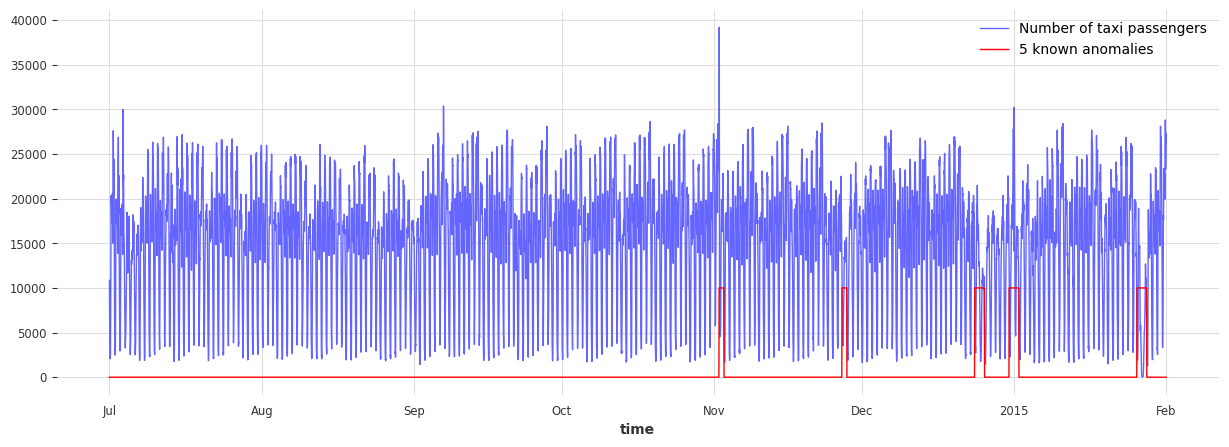

In [4]:
# load the data
series_taxi = TaxiNewYorkDataset().load()

# define start and end dates for some known anomalies
anomalies_day = {
    "NYC Marathon": ("2014-11-02 00:00", "2014-11-02 23:30"),
    "Thanksgiving ": ("2014-11-27 00:00", "2014-11-27 23:30"),
    "Christmas": ("2014-12-24 00:00", "2014-12-25 23:30"),
    "New Years": ("2014-12-31 00:00", "2015-01-01 23:30"),
    "Snow Blizzard": ("2015-01-26 00:00", "2015-01-27 23:30"),
}
anomalies_day = {
    k: (pd.Timestamp(v[0]), pd.Timestamp(v[1])) for k, v in anomalies_day.items()
}

# create a series with the binary anomaly flags
anomalies = pd.Series([0] * len(series_taxi), index=series_taxi.time_index)
for start, end in anomalies_day.values():
    anomalies.loc[(start <= anomalies.index) & (anomalies.index <= end)] = 1.0

series_taxi_anomalies = TimeSeries.from_series(anomalies)

# plot the data and the anomalies
fig, ax = plt.subplots(figsize=(15, 5))
series_taxi.plot(label="Number of taxi passengers", linewidth=1, color="#6464ff")
(series_taxi_anomalies * 10000).plot(label="5 known anomalies", color="r", linewidth=1)
plt.show()

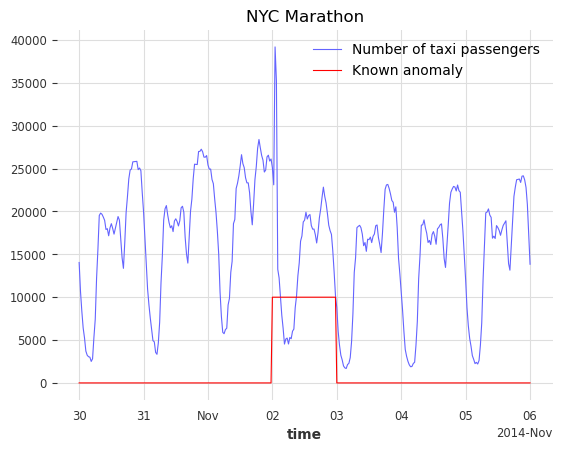

In [5]:
def plot_anom(selected_anomaly, delta_plotted_days):
    one_day = series_taxi.freq * 24 * 2
    anomaly_date = anomalies_day[selected_anomaly][0]
    start_timestamp = anomaly_date - delta_plotted_days * one_day
    end_timestamp = anomaly_date + (delta_plotted_days + 1) * one_day

    series_taxi[start_timestamp:end_timestamp].plot(
        label="Number of taxi passengers", color="#6464ff", linewidth=0.8
    )

    (series_taxi_anomalies[start_timestamp:end_timestamp] * 10000).plot(
        label="Known anomaly", color="r", linewidth=0.8
    )
    plt.title(selected_anomaly)
    plt.show()


for anom_name in anomalies_day:
    plot_anom(anom_name, 3)
    break  # remove this to see all anomalies

The goal would be to detect these five irregular periods and identify other possible abnormal days. 

## Train a Darts forecasting model

We will use a `RegressionModel` to predict the number of taxi passengers. The first 4500 timestamps will be used to train the model. The training set is considered to be anomaly-free, the five considered anomalies are located after the 4500th timestamps. The number of lags is set to 1 week, assuming the demand follows a periodicity of 1 week. To help the model, additional information on the targeted series is passed as covariates (the hour and the day of the week).


In [6]:
# split the data in a training and testing set
s_taxi_train = series_taxi[:4500]
s_taxi_test = series_taxi[4500:]

# Add covariates (hour and day of the week)
add_encoders = {
    "cyclic": {"future": ["hour", "dayofweek"]},
}

# one week corresponds to (7 days * 24 hours * 2) of 30 minutes
one_week = 7 * 24 * 2

forecasting_model = RegressionModel(
    lags=one_week,
    lags_future_covariates=[0],
    output_chunk_length=1,
    add_encoders=add_encoders,
)
forecasting_model.fit(s_taxi_train)

RegressionModel(lags=336, lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=1, output_chunk_shift=0, add_encoders={'cyclic': {'future': ['hour', 'dayofweek']}}, model=None, multi_models=True, use_static_covariates=True)

## Use a Forecasting Anomaly Model 

The anomaly model consists of two inputs:
- a fitted `GlobalForecastingModel` (you can find a list [here](https://unit8co.github.io/darts/userguide/covariates.html#global-forecasting-models-gfms). If the model hasn't been fitted, set parameter `allow_model_training` to `True` when calling `fit()`)
- a single or list of `AnomalyScorer` (trainable or not)

For this example, three scorers will be used:
- `NormScorer` (window is by default set to 1)
- `WassersteinScorer` with a half-day window (24 timestamps) and no window aggregation
- `WassersteinScorer` with a full-day window (48 timestamps) including window aggregation

The `window` parameter is an integer value indicating the window size used by the scorer to transform the series into an anomaly score. A scorer will slice the given series into subsequences of size W and returns a value indicating how anomalous these subset of W values are.

The `window_agg` can be used to transform the window-wise scores into point-wise scores by aggregating all anomaly scores from each window that the point was included in.

The following figure illustrates the mechanism of a Forecasting Anomaly model:

<img src="static/images/ad_inside_anomaly_model.png" width="800"> 

### Using the main functions: fit(), score(), eval_metric() and show_anomalies()

In [7]:
# with timestamps of 30 minutes
half_a_day = 2 * 12
full_day = 2 * 24

# instantiate the anomaly model with: one fitted model, and 3 scorers
anomaly_model = ForecastingAnomalyModel(
    model=forecasting_model,
    scorer=[
        NormScorer(ord=1),
        WassersteinScorer(window=half_a_day, window_agg=False),
        WassersteinScorer(window=full_day, window_agg=True),
    ],
)

Now let's train the anomaly model with `fit()`. In sequence it will:

- fit the forecasting model on the given series if it has not been fitted yet and `allow_model_training=True`.
- generate historical forecasts for the given series.
- feed the historical forecasts to each fittable/trainable scorer:
    - compute the differences between the forecasts and the given series (controled by the scorers `diff_fn`, see Darts "per time step" metrics [here](https://unit8co.github.io/darts/generated_api/darts.metrics.html))
    - train the scorer on these differences

You can control how the historical forecasts are generated when calling `fit()` (the supported parameters are [here](https://unit8co.github.io/darts/generated_api/darts.ad.anomaly_model.forecasting_am.html#darts.ad.anomaly_model.forecasting_am.ForecastingAnomalyModel.fit)).

In [8]:
START = 0.1
anomaly_model.fit(s_taxi_train, start=START, allow_model_training=False, verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]

We call the function `score()` to compute the anomaly scores of a new series `s_taxi_test`. It returns the scores from each scorer in the anomaly model. We will use the results in the next section. With `return_model_prediction=True`, we can additionally get the historical forecasts generated by the forecasting model.

In [9]:
anomaly_scores, model_forecasting = anomaly_model.score(
    s_taxi_test, start=START, return_model_prediction=True, verbose=True
)
pred_start = model_forecasting.start_time()

  0%|          | 0/1 [00:00<?, ?it/s]

On testing set -> MAE: 595.190366262045, RMSE: 896.6287614972252


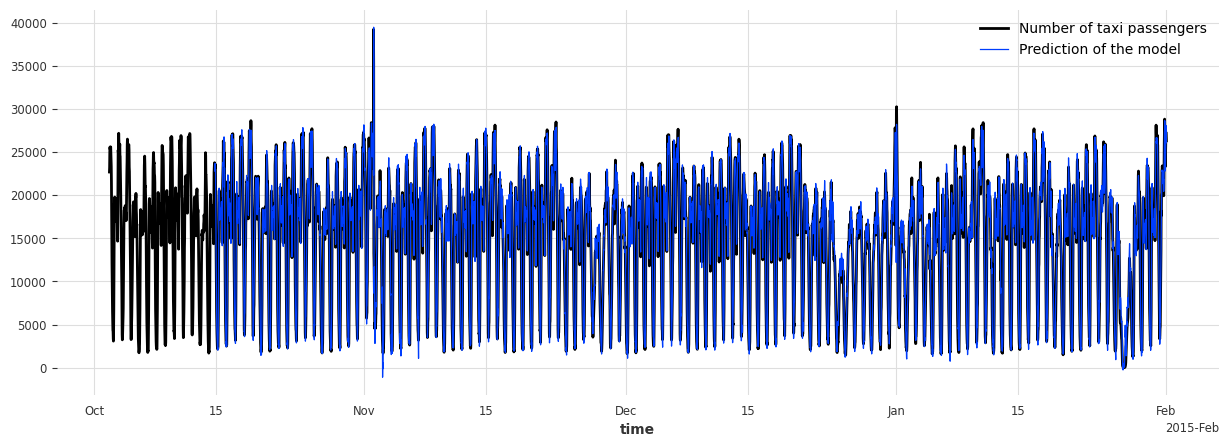

In [10]:
# compute the MAE and RMSE on the test set
print(
    f"On testing set -> MAE: {mae(model_forecasting, s_taxi_test)}, RMSE: {rmse(model_forecasting, s_taxi_test)}"
)

# plot the data and the anomalies
fig, ax = plt.subplots(figsize=(15, 5))
s_taxi_test.plot(label="Number of taxi passengers")
model_forecasting.plot(label="Prediction of the model", linewidth=0.9)
plt.show()

To evaluate the anomaly model, we call the function `eval_metric()`. It outputs the score of an agnostic threshold metric ("AUC-ROC" or "AUC-PR"), between the predicted anomaly score time series and some known binary ground-truth time series indicating the presence of actual anomalies. 

It will return a dictionary containing the name of the scorer and its score.

In [11]:
metric_names = ["AUC_ROC", "AUC_PR"]
metric_data = []
for metric_name in metric_names:
    metric_data.append(
        anomaly_model.eval_metric(
            anomalies=series_taxi_anomalies,
            series=s_taxi_test,
            start=START,
            metric=metric_name,
        )
    )
pd.DataFrame(data=metric_data, index=metric_names).T

,AUC_ROC,AUC_PR
Norm (ord=1)_w=1,0.658074,0.215601
WassersteinScorer_w=24,0.884915,0.609469
WassersteinScorer_w=48,0.950035,0.687788


We can see that the anomaly model, using the `WassersteinScorer`, can separate the abnormal days from the normal ones. The AUC ROC is above 0.9. Additionally, a window of size 48 timestamps (24 hours) is a better option than a window of size 24 timestamps (12 hours). 

We call the function `show_anomalies()` to visualize the results. It plots the forecasts, predicted scores, the input series, and the actual anomalies (if provided). The scorers with different windows will be separated. It is possible to compute a metric that will be shown next to the scorer’s name. 

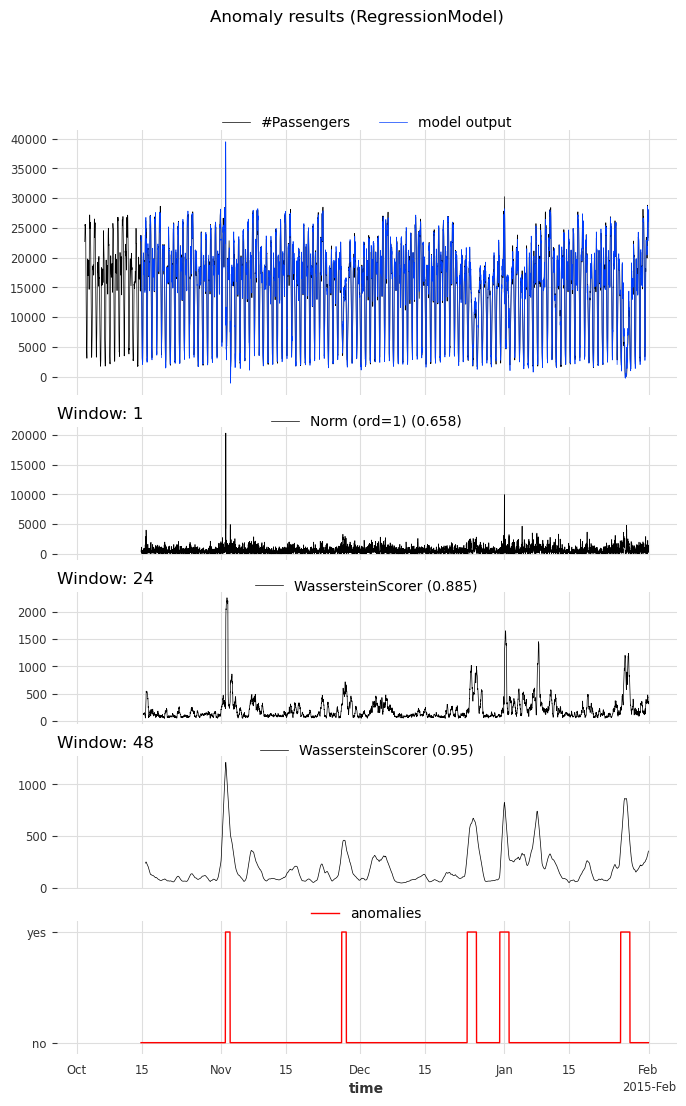

In [12]:
anomaly_model.show_anomalies(
    series=s_taxi_test,
    anomalies=series_taxi_anomalies[pred_start:],
    start=START,
    metric="AUC_ROC",
)

# Convert an anomaly score to a binary prediction with a `Detector`

Darts' Anomaly Detectors convert anomaly scores into binary anomlies/predictions. In this example, we'll use the `QuantileDetector`.

It detects anomalies based on the quantile values (`high_quantile` and/or `low_quantile`) of historical data. It flags times as anomalous when the values exceed these quantile thresholds. In this example, the anomaly scores were computed for the absolute residuals of the model. It is lower-bound by 0. We set `low_quantile=None` (default), as we only want to flag values above `high_quantile`. 

We set `high_quantile` to `0.95`. This value must be chosen carefully, as it will convert the `(1- high_quantile) * 100` % biggest anomaly scores into a prediction of anomalies. In our case, we want to see the 5% most anomalous timestamps. 

> Note: You can also use `ThresholdDetector` to define some fixed value thresholds for anomaly detection

In [13]:
from darts.ad.detectors import QuantileDetector

contamination = 0.95
detector = QuantileDetector(high_quantile=contamination)

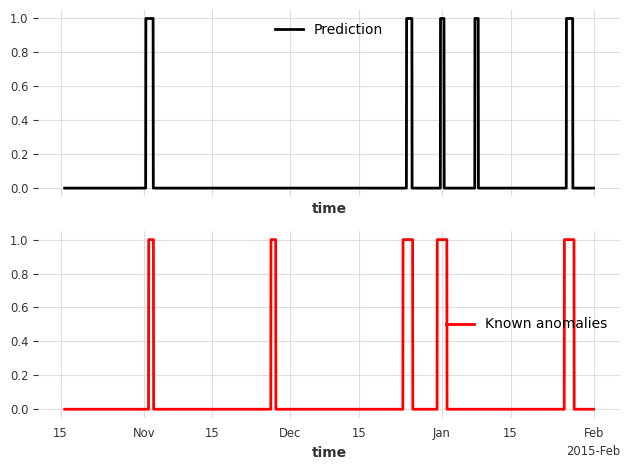

In [14]:
# use the anomaly score that gave the best AUC ROC score: Wasserstein anomaly score with a window of 'full_day'
best_anomaly_score = anomaly_scores[-1]

# fit and detect on the anomaly scores, it will return a binary prediction
anomaly_pred = detector.fit_detect(series=best_anomaly_score)

# plot the binary prediction
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
anomaly_pred.plot(label="Prediction", ax=ax1)
series_taxi_anomalies[anomaly_pred.start_time() :].plot(
    label="Known anomalies", ax=ax2, color="red"
)
fig.tight_layout()

In [15]:
for metric_name in ["accuracy", "precision", "recall", "f1"]:
    metric_val = detector.eval_metric(
        pred_scores=best_anomaly_score,
        anomalies=series_taxi_anomalies,
        window=full_day,
        metric=metric_name,
    )
    print(metric_name + f": {metric_val:.2f}/1")

accuracy: 0.91/1
precision: 0.76/1
recall: 0.32/1
f1: 0.45/1


### Using the functions show_anomalies_from_scores(), eval_metric_from_scores()

Internally, methods `eval_metric()` and `show_anomalies()` call `eval_metric_from_scores()` and `show_anomalies_from_scores()`, respectively. We can also call them directly with pre-computed anomaly scores to avoid having to re-generate the scores each time.

Let's reproduce the results from above. Both functions require the window sizes used to compute each of the anomaly scores. In our case, the window sizes were `1, 24 (half_a_day), 48 (full_day)`.

In [16]:
windows = [1, half_a_day, full_day]
scorer_names = [f"{scorer}_{w}" for scorer, w in zip(anomaly_model.scorers, windows)]

metric_data = {"AUC_ROC": [], "AUC_PR": []}
for metric_name in metric_data:
    metric_data[metric_name] = eval_metric_from_scores(
        anomalies=series_taxi_anomalies,
        pred_scores=anomaly_scores,
        window=windows,
        metric=metric_name,
    )

pd.DataFrame(index=scorer_names, data=metric_data)

,AUC_ROC,AUC_PR
Norm (ord=1)_1,0.658074,0.215601
WassersteinScorer_24,0.884915,0.609469
WassersteinScorer_48,0.950035,0.687788


As expected, the AUC ROC and AUC PR values are identical to before.

For visualizing the anomalies:

- if we want to compute a metric, we need to specify the window sizes as well
- optionally, we can indicate the scorers’ names that generated the scores

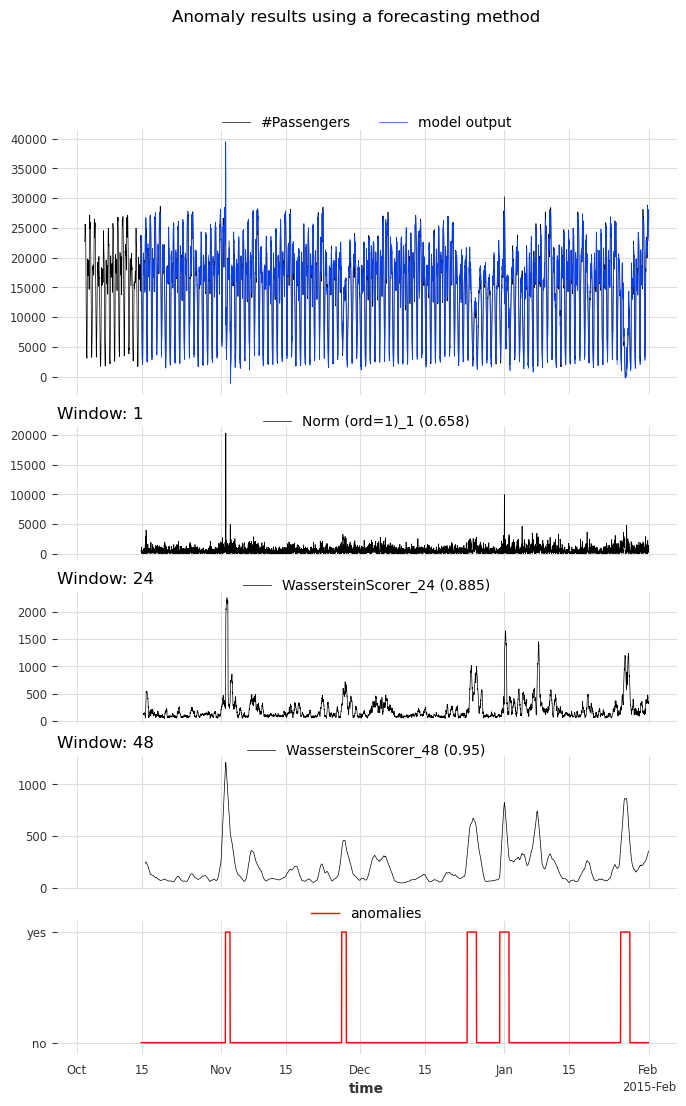

In [17]:
show_anomalies_from_scores(
    series=s_taxi_test,
    anomalies=series_taxi_anomalies[pred_start:],
    pred_scores=anomaly_scores,
    pred_series=model_forecasting,
    window=windows,
    title="Anomaly results using a forecasting method",
    names_of_scorers=scorer_names,
    metric="AUC_ROC",
)

# A zoom on each anomalies: visualize the results

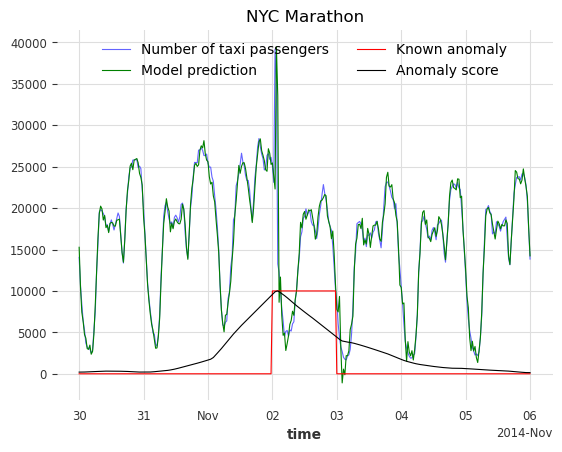

In [18]:
def plot_anom_eval(selected_anomaly, delta_plotted_days):
    one_day = series_taxi.freq * 24 * 2
    anomaly_date = anomalies_day[selected_anomaly][0]
    start = anomaly_date - one_day * delta_plotted_days
    end = anomaly_date + one_day * (delta_plotted_days + 1)

    # input series and forecasts
    series_taxi[start:end].plot(
        label="Number of taxi passengers", color="#6464ff", linewidth=0.8
    )
    model_forecasting[start:end].plot(
        label="Model prediction", color="green", linewidth=0.8
    )

    # actual anomalies and predicted scores
    (series_taxi_anomalies[start:end] * 10000).plot(
        label="Known anomaly", color="r", linewidth=0.8
    )
    # Scaler transforms scores into a value range between (0, 1)
    (Scaler().fit_transform(best_anomaly_score)[start:end] * 10000).plot(
        label="Anomaly score", color="black", linewidth=0.8
    )
    plt.legend(loc="upper center", ncols=2)
    plt.title(selected_anomaly)
    fig.tight_layout()
    plt.show()


for anom_name in anomalies_day:
    plot_anom_eval(anom_name, 3)
    break  # remove this to see all anomalies

# Simple case: `KMeansScorer`

Let's have a closer look at the scorer's `window` parameter on the example of the `KmeansScorer`. We'll use two toy datasets to demonstrate how the scorers perform with different window sizes. In first example we set `window=1` on a multivariate time series, and in the second we set `window=2` on a univariate time series. 

The figure below illustrates the Scorer's windowing process:

<img src="static/images/ad_windowing.png" width="1000">

## Multivariate case with window=1 

### Synthetic data creation

The data is a multivariate series (2 components/columns). Each step has either value of `0` or `1`, and the two components always have opposite values:

In [19]:
pd.DataFrame(index=["State 1", "State 2"], data={"comp1": [0, 1], "comp2": [1, 0]})

,comp1,comp2
State 1,0,1
State 2,1,0


At each timestamp, it has a 50% chance to switch state and a 50% chance to keep the same state. 

#### Train set

In [20]:
def generate_data_ex1(random_state: int):
    np.random.seed(random_state)

    # create the train set
    comp1 = np.expand_dims(np.random.choice(a=[0, 1], size=100, p=[0.5, 0.5]), axis=1)
    comp2 = (comp1 == 0).astype(float)
    vals = np.concatenate([comp1, comp2], axis=1)
    return vals

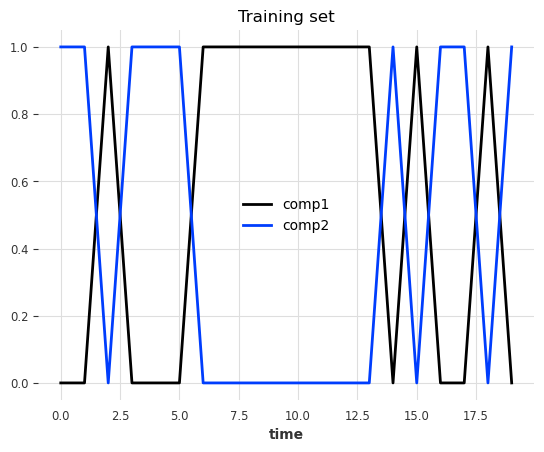

In [21]:
data = generate_data_ex1(random_state=40)
series_train = TimeSeries.from_values(data, columns=["comp1", "comp2"])

# visualize the train set
series_train[:20].plot()
plt.title("Training set")
plt.show()

#### Test set

We create the test set using the same rules as the train set but we'll inject six anomalies of three different types. The anomalies can be longer than one timestamp. The types are:

- 1st type: replacing the value of one component (0 or 1) with 2
- 2nd type: adding +1 or -1 to both components
- 3rd type: both components have the same value

In [22]:
# inject anomalies in the test timeseries
data = generate_data_ex1(random_state=3)

# 2 anomalies per type
# type 1: random values for only one component
data[20:21, 0] = 2
data[30:32, 1] = 2

# type 2: shift both components values (+/- 1 for both components)
data[45:47, :] += 1
data[60:64, :] -= 1

# type 3: switch one value to the another
data[75:82, 0] = data[75:82, 1]
data[90:96, 1] = data[90:96, 0]

series_test = TimeSeries.from_values(data, columns=["component 1", "component 2"])

# create the binary anomalies ground truth series
anomalies = ~((data == [0, 1]).all(axis=1) | (data == [1, 0]).all(axis=1))
anomalies = TimeSeries.from_times_and_values(
    times=series_test.time_index, values=anomalies, columns=["is_anomaly"]
)

Let's look at the anomalies. From left to right, the first two anomalies correspond to the first type, the third and the fourth correspond to the second type, and the last two to the third type.


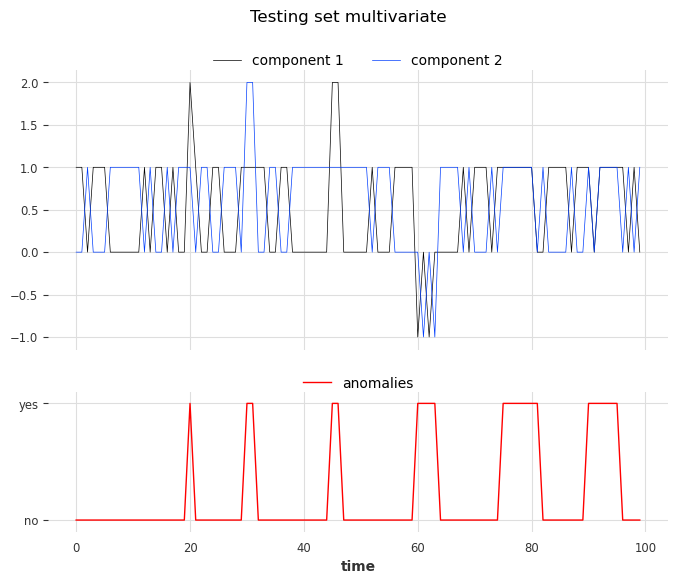

In [23]:
show_anomalies_from_scores(
    series=series_test, anomalies=anomalies, title="Testing set multivariate"
)

### Use the scorer `KMeansScorer()`

We'll use the `KMeansScorer` to locate the anomalies with the following parameters:

- `k`=2: The number of clusters/centroids generated by the KMeans model. We choose two since we know that there are only two valid states.
- `window`=1 (default): Each timestamp is considered independently by the KMeans model. It indicates the size of the window used to create the subsequences of the series (`window` is identical to a positive target `lag` for our [regression models](https://unit8co.github.io/darts/examples/20-RegressionModel-examples.html#Darts-Regression-Models)). In this example we know that each anomaly can be detected by only looking one step.
- `component_wise`=False (default): All components are used together as features with a single KMeans model. If `True`, we would fit a dedicated model per component. For this example we need information about both components to find all anomalies.

We'll fit `KMeansScorer` on the anomaly-free training series, compute the anomaly scores on the test series, and finally evaluate the scores.

In [24]:
Kmeans_scorer = KMeansScorer(k=2, window=1, component_wise=False)

# fit the KmeansScorer on the train timeseries 'series_train'
Kmeans_scorer.fit(series_train)

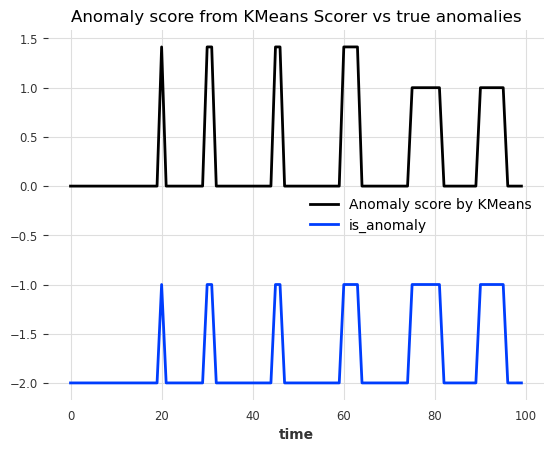

In [25]:
anomaly_score = Kmeans_scorer.score(series_test)

# visualize the anomaly score compared to the true anomalies
anomaly_score.plot(label="Anomaly score by KMeans")
(anomalies - 2).plot()
plt.title("Anomaly score from KMeans Scorer vs true anomalies")
plt.show()

Nice! We can see that the anomaly scores accurately indicate the position of the 6 anomalies.

To evaluate the scores, we can call `eval_metric()`. It expects the true anomalies, the series, and the name of the agnostic threshold metric (AUC-ROC or AUC-PR).

In [26]:
for metric_name in ["AUC_ROC", "AUC_PR"]:
    metric_val = Kmeans_scorer.eval_metric(anomalies, series_test, metric=metric_name)
    print(metric_name + f": {metric_val}")

AUC_ROC: 1.0
AUC_PR: 1.0


And again, let's visualize the results with `show_anomalies()`:

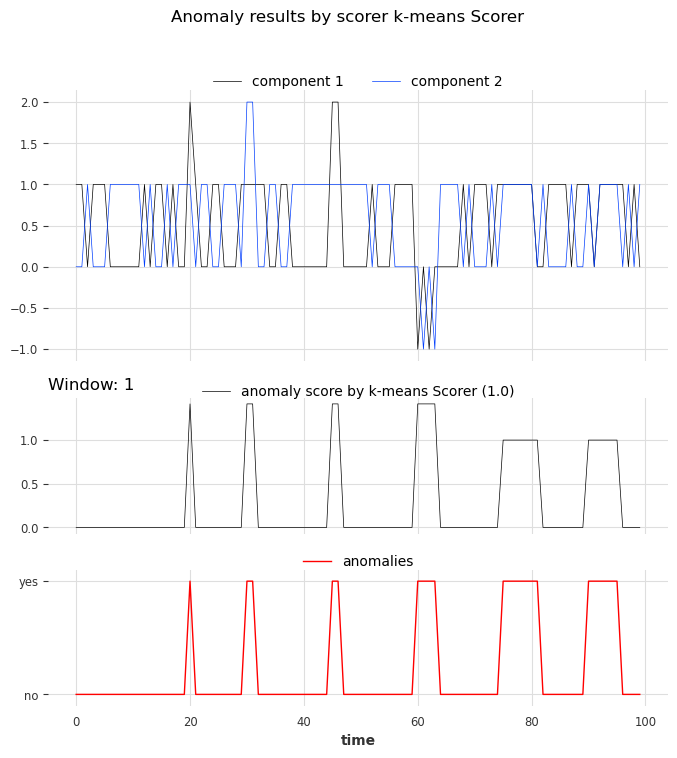

In [27]:
Kmeans_scorer.show_anomalies(series=series_test, anomalies=anomalies, metric="AUC_ROC")

## Univariate case with window>1 

In the previous example, we used `window=1` which was sufficient to identify all anomalies. In the next example, we'll see that sometimes higher values are required to capture the true anomalies.

### Synthetic data creation

#### Train set

In this toy example, we generate a univariate (one component) series that can take 4 possible values.

- possible values at each step `(0, 1, 2, 3)`
- every next step either adds `diff=+1` or subtracts `diff=-1` (50% chance)
- all steps are upper- and lower-bounded
  - `0` and `diff=-1` remains at `0`
  - `3` and `diff=+1` remains at `3`

In [28]:
def generate_data_ex2(start_val: int, random_state: int):
    np.random.seed(random_state)
    # create the test set
    vals = np.zeros(100)

    vals[0] = start_val

    diffs = np.random.choice(a=[-1, 1], p=[0.5, 0.5], size=len(vals) - 1)
    for i in range(1, len(vals)):
        vals[i] = vals[i - 1] + diffs[i - 1]
        if vals[i] > 3:
            vals[i] = 3
        elif vals[i] < 0:
            vals[i] = 0
    return vals

Text(0.5, 1.0, 'Training set')

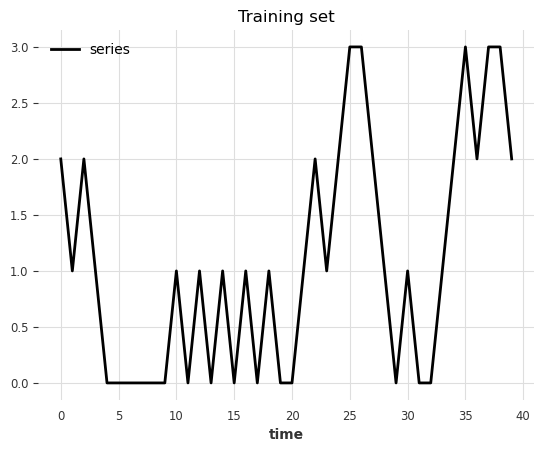

In [29]:
data = generate_data_ex2(start_val=2, random_state=1)
series_train = TimeSeries.from_values(data, columns=["series"])

# visualize the train set
series_train[:40].plot()
plt.title("Training set")

#### Test set

We create the test set using the same rules as the train set but we'll inject six anomalies of two different types. The anomalies can be longer than one timestamp:

- Type 1: steps with `abs(diff) > 1` (jumps larger than one)
- Type 2: steps with `diff = 0` at values `(1, 2)` (value remains constant)

In [30]:
data = generate_data_ex2(start_val=1, random_state=3)

# 3 anomalies per type
# type 1: sudden shift between state 0 to state 2 without passing by value 1
data[23] = 3
data[44] = 3
data[91] = 0

# type 2: having consecutive timestamps at value 1 or 2
data[3:5] = 2
data[17:19] = 1
data[62:65] = 2

series_test = TimeSeries.from_values(data, columns=["series"])

# identify the anomalies
diffs = np.abs(data[1:] - data[:-1])
anomalies = ~((diffs == 1) | ((diffs == 0) & np.isin(data[1:], [0, 3])))
# the first step is not an anomaly
anomalies = np.concatenate([[False], anomalies]).astype(int)

anomalies = TimeSeries.from_times_and_values(
    series_test.time_index, anomalies, columns=["is_anomaly"]
)

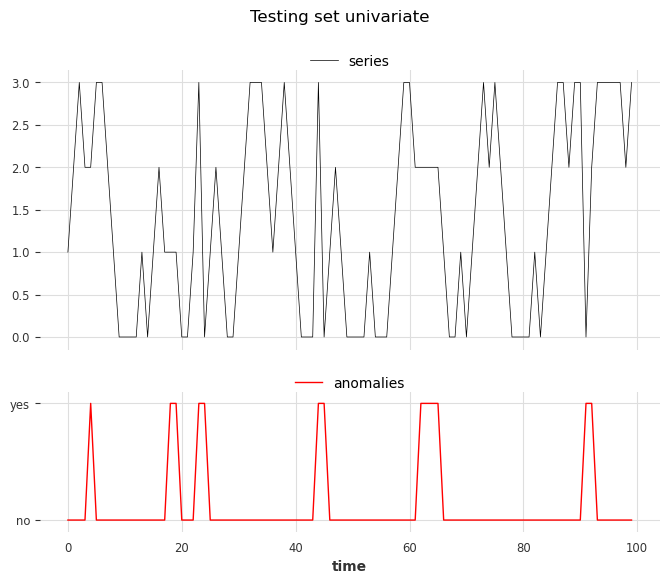

In [31]:
show_anomalies_from_scores(
    series=series_test, anomalies=anomalies, title="Testing set univariate"
)
plt.show()

From left to right, anomalies at positions 3, 4, and 6 are of type 1, and anomalies at positions 1, 2, and 5 are of type 2. 

### Use the scorer `KMeansScorer()`

We fit two `KMeansScorer` with different values for the `window` parameter (1 and 2).

In [32]:
windows = [1, 2]
Kmeans_scorer_w1 = KMeansScorer(k=4, window=windows[0])
Kmeans_scorer_w2 = KMeansScorer(k=8, window=windows[1], window_agg=False)

In [33]:
scores_all = []
metric_data = {"AUC_ROC": [], "AUC_PR": []}
for model, window in zip([Kmeans_scorer_w1, Kmeans_scorer_w2], windows):
    model.fit(series_train)
    scores = model.score(series_test)
    scores_all.append(scores)

    for metric_name in metric_data:
        metric_data[metric_name].append(
            eval_metric_from_scores(
                anomalies=anomalies,
                pred_scores=scores,
                metric=metric_name,
            )
        )
pd.DataFrame(data=metric_data, index=["w_1", "w_2"])

,AUC_ROC,AUC_PR
w_1,0.460212,0.123077
w_2,1.000000,1.000000


The metric indicates that the scorer with the parameter window set to 1 cannot locate the anomalies. On the other hand, the scorer with the parameter set to 2 perfectly identified the anomalies.

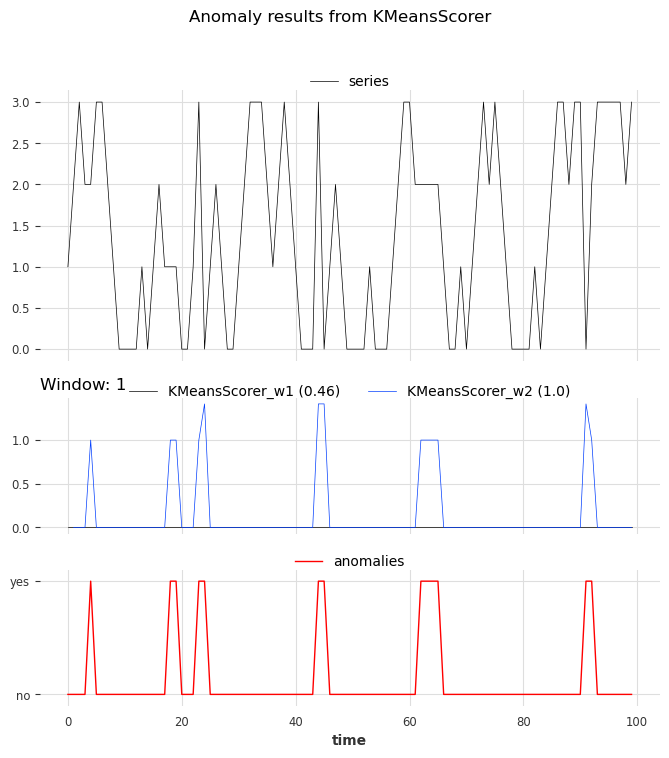

In [34]:
show_anomalies_from_scores(
    series=series_test,
    anomalies=anomalies,
    pred_scores=scores_all,
    names_of_scorers=["KMeansScorer_w1", "KMeansScorer_w2"],
    metric="AUC_ROC",
    title="Anomaly results from KMeansScorer",
)

We can see the accurate prediction of the scorer with a window of 2 compared to that of the scorer with a window of 1. 